In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import LabelEncoder

df_violent_parsed = pd.read_csv("C:\\Users\\Karthik Sundaram\\Documents\\ethics pro\\compas\\cox-violent-parsed.csv")

In [86]:
# Drop variables that are not needed
columns_to_drop = ['id', 'first', 'last', 'in_custody', 'vr_charge_desc', 'r_case_number', 'vr_charge_degree', 
                   'c_offense_date', 'c_case_number', 'r_offense_date', 'juv_other_count', 'end', 'event', 
                   'screening_date', 'start', 'juv_misd_count', 'juv_fel_count', 'r_days_from_arrest', 
                   'r_charge_degree', 'days_b_screening_arrest', 'vr_case_number', 'priors_count.1', 'r_jail_out', 
                   'c_arrest_date', 'r_charge_desc', 'r_jail_in', 'violent_recid', 'decile_score.1', 
                   'vr_offense_date', 'out_custody']

df_violent_parsed.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

In [87]:
df_violent_parsed

,name,compas_screening_date,sex,dob,age,age_cat,race,decile_score,priors_count,c_jail_in,...,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,type_of_assessment,score_text,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date
0,miguel hernandez,14-08-2013,Male,18-04-1947,69,Greater than 45,Other,1,0,13-08-2013 06:03,...,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,14-08-2013
1,miguel hernandez,14-08-2013,Male,18-04-1947,69,Greater than 45,Other,1,0,13-08-2013 06:03,...,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,14-08-2013
2,michael ryan,31-12-2014,Male,06-02-1985,31,25 - 45,Caucasian,5,0,NaN,...,NaN,NaN,-1,0,Risk of Recidivism,Medium,Risk of Violence,2,Low,31-12-2014
3,kevon dixon,27-01-2013,Male,22-01-1982,34,25 - 45,African-American,3,0,26-01-2013 03:45,...,(F3),Felony Battery w/Prior Convict,1,1,Risk of Recidivism,Low,Risk of Violence,1,Low,27-01-2013
4,ed philo,14-04-2013,Male,14-05-1991,24,Less than 25,African-American,4,4,13-04-2013 04:58,...,(F3),Possession of Cocaine,1,0,Risk of Recidivism,Low,Risk of Violence,3,Low,14-04-2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,alexsandra beauchamps,29-12-2014,Female,21-12-1984,31,25 - 45,African-American,6,5,28-12-2014 10:14,...,(M1),Battery,0,0,Risk of Recidivism,Medium,Risk of Violence,4,Low,29-12-2014
18312,winston gregory,14-01-2014,Male,01-10-1958,57,Greater than 45,Other,1,0,13-01-2014 05:48,...,(F2),Aggravated Battery / Pregnant,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,14-01-2014
18313,farrah jean,09-03-2014,Female,17-11-1982,33,25 - 45,African-American,2,3,08-03-2014 08:06,...,(M1),Battery on Law Enforc Officer,0,0,Risk of Recidivism,Low,Risk of Violence,2,Low,09-03-2014
18314,florencia sanmartin,30-06-2014,Female,18-12-1992,23,Less than 25,Hispanic,4,2,28-06-2014 12:16,...,(F3),Possession of Ethylone,1,0,Risk of Recidivism,Low,Risk of Violence,4,Low,30-06-2014


In [88]:
df_violent_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   18316 non-null  object 
 1   compas_screening_date  18316 non-null  object 
 2   sex                    18316 non-null  object 
 3   dob                    18316 non-null  object 
 4   age                    18316 non-null  int64  
 5   age_cat                18316 non-null  object 
 6   race                   18316 non-null  object 
 7   decile_score           18316 non-null  int64  
 8   priors_count           18316 non-null  int64  
 9   c_jail_in              17019 non-null  object 
 10  c_jail_out             17019 non-null  object 
 11  c_days_from_compas     17449 non-null  float64
 12  c_charge_degree        17449 non-null  object 
 13  c_charge_desc          17435 non-null  object 
 14  is_recid               18316 non-null  int64  
 15  is

In [89]:
# Check the column names in the DataFrame
print(df_violent_parsed.columns)

Index(['name', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race',
       'decile_score', 'priors_count', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'is_violent_recid', 'type_of_assessment', 'score_text',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date'],
      dtype='object')


In [90]:
df_violent_parsed.shape

(18316, 22)

In [92]:
df = df_violent_parsed.dropna(subset=['decile_score', 'is_violent_recid', 'race', 'sex', 'age_cat'])

In [93]:
# Drop rows with missing values in key columns
df_violent_parsed_clean = df_violent_parsed.dropna(subset=['decile_score', 'priors_count', 'race', 
                                                           'sex', 'age_cat', 'is_violent_recid', 'v_decile_score', 'is_recid'])

# Selecting features (X) and target (Y)
X = df_violent_parsed_clean[['decile_score', 'priors_count', 'race', 
                             'sex', 'age_cat', 'is_violent_recid', 'v_decile_score']]
Y = df_violent_parsed_clean['is_recid']

# Encode 'race' column as it's categorical
label_encoder = LabelEncoder()
X['race'] = label_encoder.fit_transform(X['race'])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print shapes of train and test sets
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (14652, 7), Testing set: (3664, 7)


C:\Users\Karthik Sundaram\AppData\Local\Temp\ipykernel_46836\4209390242.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['race'] = label_encoder.fit_transform(X['race'])


In [94]:
# Encode 'race' column as it's categorical using .loc to avoid SettingWithCopyWarning
X.loc[:, 'race'] = label_encoder.fit_transform(X['race'])

C:\Users\Karthik Sundaram\AppData\Local\Temp\ipykernel_46836\771305486.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5 5 2 ... 0 3 3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[:, 'race'] = label_encoder.fit_transform(X['race'])


In [95]:
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

In [96]:
print(np.unique(Y_train))

[-1  0  1]


In [97]:
from sklearn.preprocessing import LabelEncoder

# Encoding 'sex' column
label_encoder_sex = LabelEncoder()
X_train['sex'] = label_encoder_sex.fit_transform(X_train['sex'])

# Check the result
print(X_train['sex'].unique())

[1 0]


In [98]:
from sklearn.preprocessing import LabelEncoder

# Assuming Y_train contains the class labels [-1, 0, 1], we shift them to [0, 1, 2]
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)

In [100]:
from sklearn.preprocessing import LabelEncoder

# Convert age_cat to numeric
label_encoder = LabelEncoder()
X_train['age_cat'] = label_encoder.fit_transform(X_train['age_cat'])

# Proceed with model fitting
grid_search.fit(X_train, Y_train_encoded)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [102]:
# Update preprocessor to one-hot encode 'age_cat' as well
preprocessor = ColumnTransformer(
    transformers=[
        ('sex', OneHotEncoder(handle_unknown='ignore'), ['sex']),  # One-hot encode the 'sex' column
        ('age_cat', OneHotEncoder(handle_unknown='ignore'), ['age_cat']),  # One-hot encode the 'age_cat' column
        ('rest', 'passthrough', X_train.columns.difference(['sex', 'age_cat']))  # Pass through other columns without modification
    ]
)

# Create the pipeline with preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_xgb_model)  # Use the model with best parameters
])

# Fit the pipeline
pipeline.fit(X_train, Y_train_encoded)

# Make predictions
Y_pred_best = pipeline.predict(X_test)
Y_pred_best_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the results
print("Predictions:", Y_pred_best)
print("Prediction Probabilities:", Y_pred_best_prob)

Predictions: [1 1 1 ... 1 1 2]
Prediction Probabilities: [0.76220745 0.77878577 0.5684023  ... 0.73824227 0.7408727  0.29756197]


hyp

In [104]:
print("Unique values in Y_train:", Y_train.unique())

Unique values in Y_train: [ 0  1 -1]


In [105]:
# Replace -1 with 0 or 1 based on your understanding of the data
Y_train = Y_train.replace(-1, 0)  # or Y_train.replace(-1, 1) if you prefer

In [107]:
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [108]:
# Check the data types of X_train
print(X_train.dtypes)

# Ensure no object types are present, or convert them appropriately.

decile_score        int64
priors_count        int64
race                int32
sex                 int32
is_violent_recid    int64
v_decile_score      int64
age_cat_0            bool
age_cat_1            bool
age_cat_2            bool
dtype: object


In [109]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Best parameters
print("Best Parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters:  {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}


train

In [110]:
best_xgb = grid_search.best_estimator_

In [111]:
# Check unique values in Y
print("Unique values in Y before replacing: ", Y.unique())

# Ensure no -1 values in Y
Y = Y.replace(-1, 0)

# Verify after replacing
print("Unique values in Y after replacing: ", Y.unique())

Unique values in Y before replacing:  [ 0 -1  1]
Unique values in Y after replacing:  [0 1]


stratified kfold cross

In [112]:
print(X.columns)

Index(['decile_score', 'priors_count', 'race', 'sex', 'age_cat',
       'is_violent_recid', 'v_decile_score'],
      dtype='object')


In [114]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

# Specify the columns that are categorical
categorical_features = ['age_cat', 'sex', 'race']

# Specify the columns that are numeric (non-categorical)
numeric_features = X.columns.difference(categorical_features)

# One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),  # One-hot encoding for categorical columns
        ('num', 'passthrough', numeric_features)  # Pass-through for numeric columns
    ])

# Create the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42))
])

# Perform Stratified KFold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Use stratified KFold
cv_results = cross_val_score(pipeline, X, Y, cv=skf, scoring='accuracy')

print("Cross-Validation Accuracy: ", cv_results.mean())

Cross-Validation Accuracy:  0.7490723802405024


model calibrate

In [115]:
calibrated_xgb = CalibratedClassifierCV(best_xgb, method='sigmoid', cv=5)
calibrated_xgb.fit(X_train, Y_train)

c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:08:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parame

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='mlogloss',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.3, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=7,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=300, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=42, ...))

pred

In [116]:
# Print the first few rows of the dataframe to inspect the columns
print(df.head())

# Print the list of columns in the dataframe
print(df.columns)

               name compas_screening_date   sex         dob  age  \
0  miguel hernandez            14-08-2013  Male  18-04-1947   69   
1  miguel hernandez            14-08-2013  Male  18-04-1947   69   
2      michael ryan            31-12-2014  Male  06-02-1985   31   
3       kevon dixon            27-01-2013  Male  22-01-1982   34   
4          ed philo            14-04-2013  Male  14-05-1991   24   

           age_cat              race  decile_score  priors_count  \
0  Greater than 45             Other             1             0   
1  Greater than 45             Other             1             0   
2          25 - 45         Caucasian             5             0   
3          25 - 45  African-American             3             0   
4     Less than 25  African-American             4             4   

          c_jail_in  ... c_charge_degree                   c_charge_desc  \
0  13-08-2013 06:03  ...            (F3)    Aggravated Assault w/Firearm   
1  13-08-2013 06:03  ...      

In [117]:
# One-hot encode the 'age_cat' column
df_encoded = pd.get_dummies(df, columns=['age_cat'], drop_first=False)

# Check the columns to confirm the presence of the missing ones
print(df_encoded.columns)

Index(['name', 'compas_screening_date', 'sex', 'dob', 'age', 'race',
       'decile_score', 'priors_count', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'is_violent_recid', 'type_of_assessment', 'score_text',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'age_cat_25 - 45', 'age_cat_Greater than 45',
       'age_cat_Less than 25'],
      dtype='object')


In [118]:
Y = Y.replace(-1, 0)
print(Y.unique())  # Check the unique values in the target variable

[0 1]


In [73]:
print(X_train.columns)

Index(['age', 'sex', 'decile_score', 'priors_count', 'race',
       'c_days_from_compas', 'is_violent_recid', 'v_decile_score',
       'age_cat_Less than 25', 'age_cat_25 - 45', 'age_cat_Greater than 45'],
      dtype='object')


In [119]:
# Check the remaining columns after dropping unnecessary ones
print(df_violent_parsed.columns)

Index(['name', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race',
       'decile_score', 'priors_count', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'is_violent_recid', 'type_of_assessment', 'score_text',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date'],
      dtype='object')


In [120]:
print(X_train.columns)
print(X_test.columns)

Index(['decile_score', 'priors_count', 'race', 'sex', 'is_violent_recid',
       'v_decile_score', 'age_cat_0', 'age_cat_1', 'age_cat_2'],
      dtype='object')
Index(['decile_score', 'priors_count', 'race', 'sex', 'age_cat',
       'is_violent_recid', 'v_decile_score'],
      dtype='object')


In [122]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

# Update the preprocessor to handle the new column structure
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),  # Handle unknown categories
        ('num', SimpleImputer(strategy='mean'), X_train.select_dtypes(include=['float64', 'int64']).columns)  # For numerical features
    ]
)

# Create a pipeline with preprocessor and XGBoost classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

# Train the pipeline with the data
pipeline.fit(X_train, Y_train)

# Make predictions
Y_pred_best = pipeline.predict(X_test)

eval

In [123]:
print("Classification Report:\n", classification_report(Y_test, Y_pred_best))
print("Accuracy Score: ", accuracy_score(Y_test, Y_pred_best))

Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       149
           0       0.64      0.78      0.70      1785
           1       0.73      0.63      0.68      1730

    accuracy                           0.68      3664
   macro avg       0.46      0.47      0.46      3664
weighted avg       0.66      0.68      0.66      3664

Accuracy Score:  0.6763100436681223


c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

roc

In [124]:
print("Unique values in Y_test:", np.unique(Y_test))

Unique values in Y_test: [-1  0  1]


In [125]:
# Replace -1 with 0 to fix the binary labels
Y_test = np.where(Y_test == -1, 0, Y_test)

# Verify that the transformation worked
print("Unique values in Y_test after adjustment:", np.unique(Y_test))

Unique values in Y_test after adjustment: [0 1]


In [127]:
print(X_train.columns)

Index(['decile_score', 'priors_count', 'race', 'sex', 'is_violent_recid',
       'v_decile_score', 'age_cat_0', 'age_cat_1', 'age_cat_2'],
      dtype='object')


In [129]:
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

X_train columns: Index(['decile_score', 'priors_count', 'race', 'sex', 'is_violent_recid',
       'v_decile_score', 'age_cat_0', 'age_cat_1', 'age_cat_2'],
      dtype='object')
X_test columns: Index(['decile_score', 'priors_count', 'race', 'sex', 'age_cat',
       'is_violent_recid', 'v_decile_score'],
      dtype='object')


In [131]:
# Update the columns for one-hot encoding (exclude 'age_cat' because it's already encoded)
categorical_cols = ['race', 'sex']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['decile_score', 'priors_count', 'v_decile_score']),  # Numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Categorical features
    ])

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())  # Replace with your trained XGBoost model
])

# Fit the pipeline on the training data
pipeline.fit(X_train, Y_train_encoded)

# Make predictions on the test set
Y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

In [84]:
print(Y_pred_prob[:5])  # Check if these are probabilities between 0 and 1

[0.5796774  0.7791146  0.79111266 0.4117208  0.5439813 ]


ROC AUC Score:  0.25926768325851357
Precision-Recall AUC:  0.33835524528283817


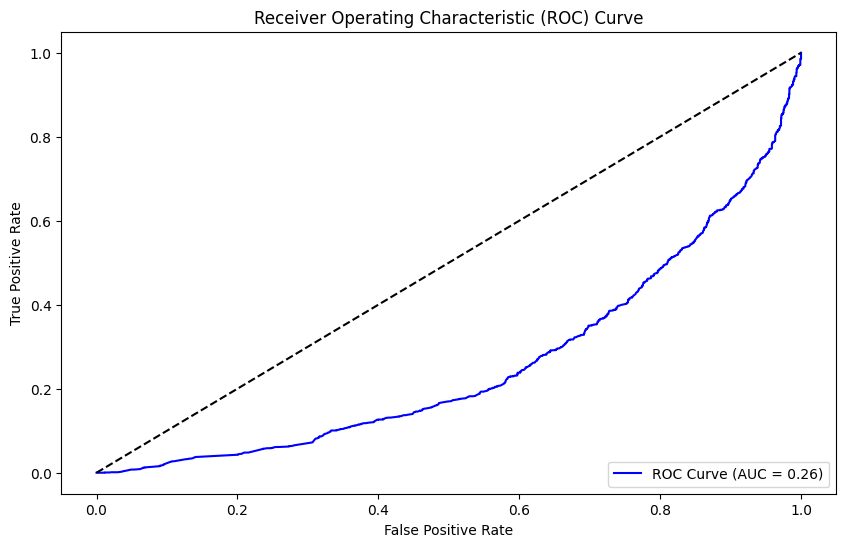

In [132]:
# Assuming Y_pred_prob is correctly in format (probabilities for the positive class)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)
print("ROC AUC Score: ", roc_auc)

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(Y_test, Y_pred_prob)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC: ", pr_auc)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [136]:
print(X_train.columns)

Index(['age', 'sex', 'decile_score', 'priors_count', 'race',
       'c_days_from_compas', 'is_violent_recid', 'v_decile_score',
       'interaction_decile_priors', 'interaction_decile_age',
       'interaction_priors_age'],
      dtype='object')


In [137]:
# Create age categories
bins = [0, 18, 30, 40, 50, 60, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '60+']
X_train['age_cat'] = pd.cut(X_train['age'], bins=bins, labels=labels, right=False)
X_test['age_cat'] = pd.cut(X_test['age'], bins=bins, labels=labels, right=False)

In [140]:
# Check for missing values in the columns of X_train and X_test
print(X_train.isnull().sum())
print(X_test.isnull().sum())

age                            0
sex                            0
decile_score                   0
priors_count                   0
race                           0
c_days_from_compas           703
is_violent_recid               0
v_decile_score                 0
interaction_decile_priors      0
interaction_decile_age         0
interaction_priors_age         0
dtype: int64
age                            0
sex                            0
decile_score                   0
priors_count                   0
race                           0
c_days_from_compas           164
is_violent_recid               0
v_decile_score                 0
interaction_decile_priors      0
interaction_decile_age         0
interaction_priors_age         0
dtype: int64


In [141]:
# Drop rows with missing values
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Make sure the target `y` is aligned with the dropped rows
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

# Verify that there are no missing values left
print(X_train.isnull().sum())
print(X_test.isnull().sum())

age                          0
sex                          0
decile_score                 0
priors_count                 0
race                         0
c_days_from_compas           0
is_violent_recid             0
v_decile_score               0
interaction_decile_priors    0
interaction_decile_age       0
interaction_priors_age       0
dtype: int64
age                          0
sex                          0
decile_score                 0
priors_count                 0
race                         0
c_days_from_compas           0
is_violent_recid             0
v_decile_score               0
interaction_decile_priors    0
interaction_decile_age       0
interaction_priors_age       0
dtype: int64


In [146]:
print(X_train.columns)
print(X_test.columns)

Index(['age', 'sex', 'decile_score', 'priors_count', 'race',
       'c_days_from_compas', 'is_violent_recid', 'v_decile_score',
       'interaction_decile_priors', 'interaction_decile_age',
       'interaction_priors_age'],
      dtype='object')
Index(['age', 'sex', 'decile_score', 'priors_count', 'race',
       'c_days_from_compas', 'is_violent_recid', 'v_decile_score',
       'interaction_decile_priors', 'interaction_decile_age',
       'interaction_priors_age'],
      dtype='object')


In [147]:
# Create age categories before splitting
bins = [0, 18, 30, 40, 50, 60, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '60+']

# Assuming X is your full dataset
X['age_cat'] = pd.cut(X['age'], bins=bins, labels=labels, right=False)

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\Karthik Sundaram\AppData\Local\Temp\ipykernel_46836\1868827094.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['age_cat'] = pd.cut(X['age'], bins=bins, labels=labels, right=False)


In [149]:
print(X.columns)  # Check if 'age_cat' exists in the full dataset

Index(['age', 'sex', 'decile_score', 'priors_count', 'race',
       'c_days_from_compas', 'is_violent_recid', 'v_decile_score',
       'interaction_decile_priors', 'interaction_decile_age',
       'interaction_priors_age', 'age_cat'],
      dtype='object')


In [151]:
print(np.unique(y_train))

[-1  0  1]


In [152]:
# Replace -1 with 0 in y_train
y_train[y_train == -1] = 0

# Do the same for y_test if needed
y_test[y_test == -1] = 0

# Check the unique values again to confirm the change
print(np.unique(y_train))
print(np.unique(y_test))

[0 1]
[0 1]


In [160]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [161]:
print("Unique values in y_train after replacement:", np.unique(y_train))
print("Unique values in y_test after replacement:", np.unique(y_test))

Unique values in y_train after replacement: [0 1]
Unique values in y_test after replacement: [0 1]


In [162]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='roc_auc')

In [163]:
# Create age categories
bins = [0, 18, 30, 40, 50, 60, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '60+']
X_train['age_cat'] = pd.cut(X_train['age'], bins=bins, labels=labels, right=False)
X_test['age_cat'] = pd.cut(X_test['age'], bins=bins, labels=labels, right=False)

# Check if the 'age_cat' column exists and has values
print(X_train['age_cat'].head())
print(X_test['age_cat'].head())

1766     0-18
17355    0-18
17930     NaN
13530    0-18
12895     NaN
Name: age_cat, dtype: category
Categories (6, object): ['0-18' < '19-30' < '31-40' < '41-50' < '51-60' < '60+']
8241      NaN
6932     0-18
9843      NaN
14968    0-18
15134     NaN
Name: age_cat, dtype: category
Categories (6, object): ['0-18' < '19-30' < '31-40' < '41-50' < '51-60' < '60+']


In [165]:
X_train = X_train.dropna(subset=['age_cat'])
X_test = X_test.dropna(subset=['age_cat'])

In [173]:
print("Unique classes in y_train:", np.unique(y_train))# Check unique values in y_train after filtering
print("Unique classes in y_train:", np.unique(y_train))

# Ensure valid classes
valid_classes = [0, 1, 2]  # Adjust this based on the unique classes you actually have
mask = y_train.isin(valid_classes)
X_train = X_train[mask]
y_train = y_train[mask]

# Recheck unique values after filtering
print("Unique values in filtered y_train:", np.unique(y_train))

# Number of classes
n_classes = len(np.unique(y_train))
if n_classes < 2:
    raise ValueError("Not enough classes for multiclass classification.")

# XGBoost model with num_class set explicitly
xgb_model = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", num_class=n_classes)

# Continue with the rest of your code...

Unique classes in y_train: [0 1]
Unique classes in y_train: [0 1]
Unique values in filtered y_train: [0 1]


In [175]:
print("Unique classes in y_test:", np.unique(y_test))

Unique classes in y_test: [-1  0  1]


ROC AUC Score for class 0: 0.93
ROC AUC Score for class 1: 0.89
ROC AUC Score for class 2: nan


c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


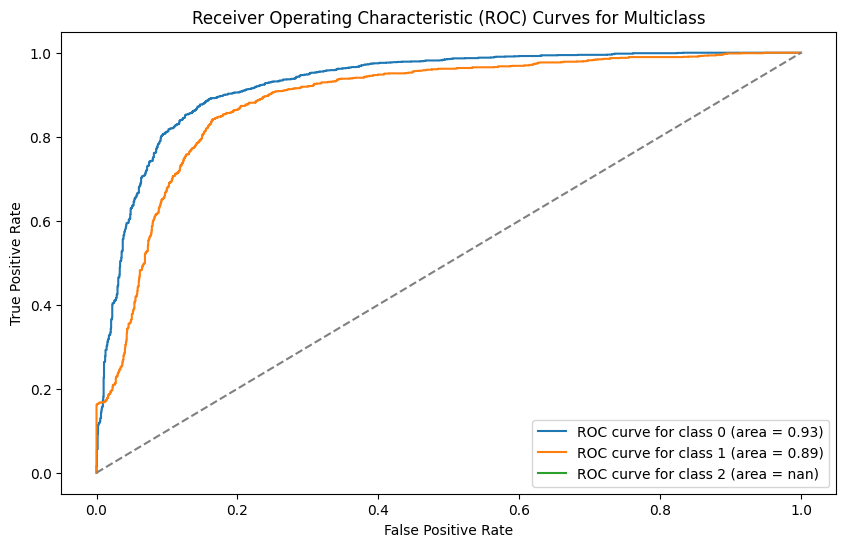

In [177]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

# XGBoost model for multiclass classification
xgb_model = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", num_class=3)

# Hyperparameter tuning (make sure to use appropriate scoring for multiclass)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc_ovr')
grid_search.fit(X_train, y_train)

# Best model after GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Model evaluation
y_pred_proba = best_xgb_model.predict_proba(X_test)

# Calculate ROC AUC for each class
roc_auc_scores = {}
for i in range(y_pred_proba.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc_scores[i] = auc(fpr, tpr)

# Print ROC AUC scores for each class
for class_label, score in roc_auc_scores.items():
    print(f"ROC AUC Score for class {class_label}: {score:.2f}")

# Plotting the ROC curves for each class can also be done
plt.figure(figsize=(10, 6))
for i in range(y_pred_proba.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve for class {i} (area = {roc_auc_scores[i]:.2f})')
    
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multiclass')
plt.legend(loc="lower right")
plt.show()

ROC AUC Score for class 0: 0.93
ROC AUC Score for class 1: 0.89


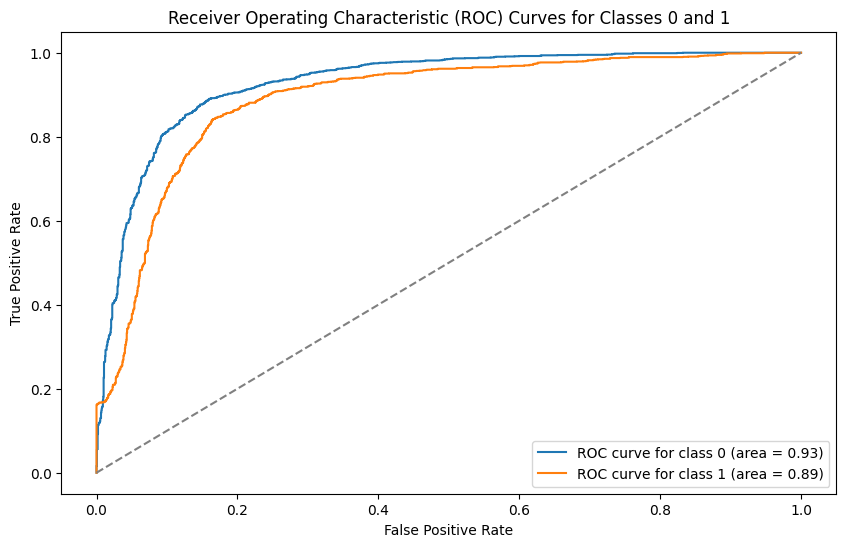

In [185]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# XGBoost model for multiclass classification
xgb_model = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", num_class=3)

# Hyperparameter tuning (ensure appropriate scoring for multiclass)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc_ovr')
grid_search.fit(X_train, y_train)

# Best model after GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Model evaluation
y_pred_proba = best_xgb_model.predict_proba(X_test)

# Calculate ROC AUC for classes 0 and 1
roc_auc_scores = {}
for i in range(2):  # Only for classes 0 and 1
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc_scores[i] = auc(fpr, tpr)

# Print ROC AUC scores for classes 0 and 1
for class_label, score in roc_auc_scores.items():
    print(f"ROC AUC Score for class {class_label}: {score:.2f}")

# Plotting the ROC curves for classes 0 and 1
plt.figure(figsize=(10, 6))
for i in range(2):  # Only for classes 0 and 1
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve for class {i} (area = {roc_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Classes 0 and 1')
plt.legend(loc="lower right")
plt.show()

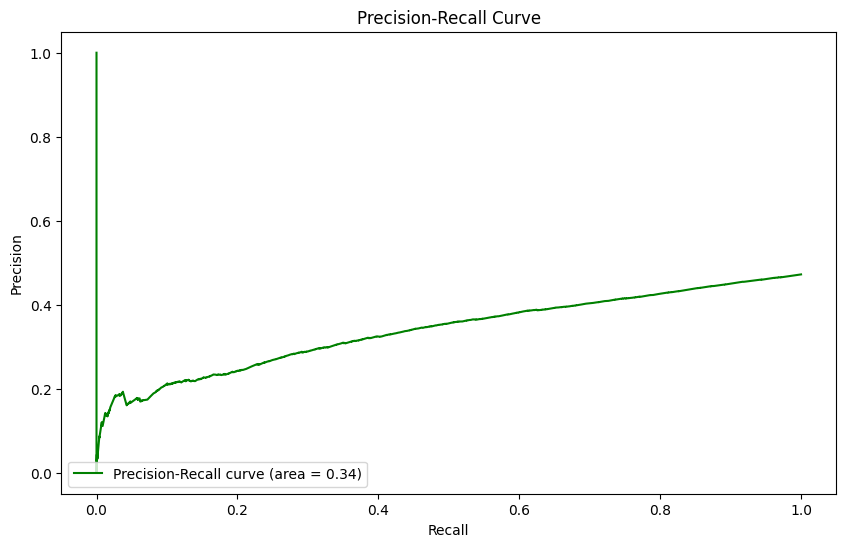

In [178]:
# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

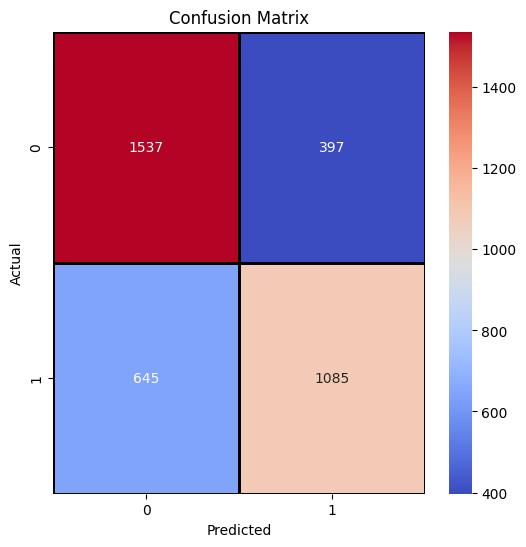

In [186]:
conf_matrix = confusion_matrix(Y_test, Y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='coolwarm', linewidths=1, linecolor='black')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [187]:
df_violent_parsed = pd.read_csv(r"C:\Users\Karthik Sundaram\Documents\ethics pro\compas\cox-violent-parsed.csv")

In [188]:
# Check the columns of X_train to verify the column names
print(X_train.columns)

# Drop 'r_jail_in' and 'r_jail_out' if they exist
X_train = X_train.drop(columns=['r_jail_in', 'r_jail_out'], errors='ignore')

# Optional: Verify the columns after dropping
print(X_train.columns)

Index(['age', 'sex', 'decile_score', 'priors_count', 'race',
       'c_days_from_compas', 'is_violent_recid', 'v_decile_score',
       'interaction_decile_priors', 'interaction_decile_age',
       'interaction_priors_age', 'age_cat'],
      dtype='object')
Index(['age', 'sex', 'decile_score', 'priors_count', 'race',
       'c_days_from_compas', 'is_violent_recid', 'v_decile_score',
       'interaction_decile_priors', 'interaction_decile_age',
       'interaction_priors_age', 'age_cat'],
      dtype='object')


In [192]:
# Assuming Y_train is derived from a DataFrame that matches X_train in index
# Recreate Y_train to ensure alignment
Y_train = Y_train[X_train.index]

In [194]:
print(X_train.shape)
print(Y_train.shape)

(13949, 12)
(13949,)


In [195]:
# We will proceed without 'c_jail_in', 'c_jail_out', 'r_jail_in', and 'r_jail_out' since they are not available in the dataset.

# Features we are working with: age, sex, decile_score, priors_count, race, c_days_from_compas, is_violent_recid, v_decile_score

# Ensure the categorical columns like 'sex' and 'race' are treated properly
X_train['sex'] = X_train['sex'].astype('category')
X_train['race'] = X_train['race'].astype('category')
X_test['sex'] = X_test['sex'].astype('category')
X_test['race'] = X_test['race'].astype('category')

# Train the XGBoost model
best_xgb = xgb.XGBClassifier(enable_categorical=True, use_label_encoder=False)

# Train the model
best_xgb.fit(X_train, Y_train)

# Make predictions
y_pred = best_xgb.predict(X_test)

# Evaluate the model (using accuracy, but you can choose other metrics as well)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8019


shap

In [196]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:49:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

age                           float64
sex                          category
decile_score                  float64
priors_count                  float64
race                         category
c_days_from_compas            float64
is_violent_recid                int64
v_decile_score                float64
interaction_decile_priors       int64
interaction_decile_age          int64
interaction_priors_age          int64
age_cat                         int32
dtype: object


c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:49:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import LabelEncoder

df_violent_parsed = pd.read_csv("C:\\Users\\Karthik Sundaram\\Documents\\ethics pro\\compas\\cox-violent-parsed.csv")

In [ ]:
# Drop variables that are not needed
columns_to_drop = ['id', 'first', 'last', 'in_custody', 'vr_charge_desc', 'r_case_number', 'vr_charge_degree', 
                   'c_offense_date', 'c_case_number', 'r_offense_date', 'juv_other_count', 'end', 'event', 
                   'screening_date', 'start', 'juv_misd_count', 'juv_fel_count', 'r_days_from_arrest', 
                   'r_charge_degree', 'days_b_screening_arrest', 'vr_case_number', 'priors_count.1', 'r_jail_out', 
                   'c_arrest_date', 'r_charge_desc', 'r_jail_in', 'violent_recid', 'decile_score.1', 
                   'vr_offense_date', 'out_custody']

df_violent_parsed.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

In [ ]:
df_violent_parsed

,name,compas_screening_date,sex,dob,age,age_cat,race,decile_score,priors_count,c_jail_in,...,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,type_of_assessment,score_text,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date
0,miguel hernandez,14-08-2013,Male,18-04-1947,69,Greater than 45,Other,1,0,13-08-2013 06:03,...,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,14-08-2013
1,miguel hernandez,14-08-2013,Male,18-04-1947,69,Greater than 45,Other,1,0,13-08-2013 06:03,...,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,14-08-2013
2,michael ryan,31-12-2014,Male,06-02-1985,31,25 - 45,Caucasian,5,0,NaN,...,NaN,NaN,-1,0,Risk of Recidivism,Medium,Risk of Violence,2,Low,31-12-2014
3,kevon dixon,27-01-2013,Male,22-01-1982,34,25 - 45,African-American,3,0,26-01-2013 03:45,...,(F3),Felony Battery w/Prior Convict,1,1,Risk of Recidivism,Low,Risk of Violence,1,Low,27-01-2013
4,ed philo,14-04-2013,Male,14-05-1991,24,Less than 25,African-American,4,4,13-04-2013 04:58,...,(F3),Possession of Cocaine,1,0,Risk of Recidivism,Low,Risk of Violence,3,Low,14-04-2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,alexsandra beauchamps,29-12-2014,Female,21-12-1984,31,25 - 45,African-American,6,5,28-12-2014 10:14,...,(M1),Battery,0,0,Risk of Recidivism,Medium,Risk of Violence,4,Low,29-12-2014
18312,winston gregory,14-01-2014,Male,01-10-1958,57,Greater than 45,Other,1,0,13-01-2014 05:48,...,(F2),Aggravated Battery / Pregnant,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,14-01-2014
18313,farrah jean,09-03-2014,Female,17-11-1982,33,25 - 45,African-American,2,3,08-03-2014 08:06,...,(M1),Battery on Law Enforc Officer,0,0,Risk of Recidivism,Low,Risk of Violence,2,Low,09-03-2014
18314,florencia sanmartin,30-06-2014,Female,18-12-1992,23,Less than 25,Hispanic,4,2,28-06-2014 12:16,...,(F3),Possession of Ethylone,1,0,Risk of Recidivism,Low,Risk of Violence,4,Low,30-06-2014


In [ ]:
df_violent_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   18316 non-null  object 
 1   compas_screening_date  18316 non-null  object 
 2   sex                    18316 non-null  object 
 3   dob                    18316 non-null  object 
 4   age                    18316 non-null  int64  
 5   age_cat                18316 non-null  object 
 6   race                   18316 non-null  object 
 7   decile_score           18316 non-null  int64  
 8   priors_count           18316 non-null  int64  
 9   c_jail_in              17019 non-null  object 
 10  c_jail_out             17019 non-null  object 
 11  c_days_from_compas     17449 non-null  float64
 12  c_charge_degree        17449 non-null  object 
 13  c_charge_desc          17435 non-null  object 
 14  is_recid               18316 non-null  int64  
 15  is

In [ ]:
# Check the column names in the DataFrame
print(df_violent_parsed.columns)

Index(['name', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race',
       'decile_score', 'priors_count', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'is_violent_recid', 'type_of_assessment', 'score_text',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date'],
      dtype='object')


In [ ]:
df_violent_parsed.shape

(18316, 22)

In [ ]:
df = df_violent_parsed.dropna(subset=['decile_score', 'is_violent_recid', 'race', 'sex', 'age_cat'])

In [ ]:
# Drop rows with missing values in key columns
df_violent_parsed_clean = df_violent_parsed.dropna(subset=['decile_score', 'priors_count', 'race', 
                                                           'sex', 'age_cat', 'is_violent_recid', 'v_decile_score', 'is_recid'])

# Selecting features (X) and target (Y)
X = df_violent_parsed_clean[['decile_score', 'priors_count', 'race', 
                             'sex', 'age_cat', 'is_violent_recid', 'v_decile_score']]
Y = df_violent_parsed_clean['is_recid']

# Encode 'race' column as it's categorical
label_encoder = LabelEncoder()
X['race'] = label_encoder.fit_transform(X['race'])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print shapes of train and test sets
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (14652, 7), Testing set: (3664, 7)


C:\Users\Karthik Sundaram\AppData\Local\Temp\ipykernel_46836\4209390242.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['race'] = label_encoder.fit_transform(X['race'])


In [ ]:
# Encode 'race' column as it's categorical using .loc to avoid SettingWithCopyWarning
X.loc[:, 'race'] = label_encoder.fit_transform(X['race'])

C:\Users\Karthik Sundaram\AppData\Local\Temp\ipykernel_46836\771305486.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5 5 2 ... 0 3 3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[:, 'race'] = label_encoder.fit_transform(X['race'])


In [ ]:
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

In [ ]:
print(np.unique(Y_train))

[-1  0  1]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encoding 'sex' column
label_encoder_sex = LabelEncoder()
X_train['sex'] = label_encoder_sex.fit_transform(X_train['sex'])

# Check the result
print(X_train['sex'].unique())

[1 0]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming Y_train contains the class labels [-1, 0, 1], we shift them to [0, 1, 2]
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert age_cat to numeric
label_encoder = LabelEncoder()
X_train['age_cat'] = label_encoder.fit_transform(X_train['age_cat'])

# Proceed with model fitting
grid_search.fit(X_train, Y_train_encoded)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [ ]:
# Update preprocessor to one-hot encode 'age_cat' as well
preprocessor = ColumnTransformer(
    transformers=[
        ('sex', OneHotEncoder(handle_unknown='ignore'), ['sex']),  # One-hot encode the 'sex' column
        ('age_cat', OneHotEncoder(handle_unknown='ignore'), ['age_cat']),  # One-hot encode the 'age_cat' column
        ('rest', 'passthrough', X_train.columns.difference(['sex', 'age_cat']))  # Pass through other columns without modification
    ]
)

# Create the pipeline with preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_xgb_model)  # Use the model with best parameters
])

# Fit the pipeline
pipeline.fit(X_train, Y_train_encoded)

# Make predictions
Y_pred_best = pipeline.predict(X_test)
Y_pred_best_prob = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the results
print("Predictions:", Y_pred_best)
print("Prediction Probabilities:", Y_pred_best_prob)

Predictions: [1 1 1 ... 1 1 2]
Prediction Probabilities: [0.76220745 0.77878577 0.5684023  ... 0.73824227 0.7408727  0.29756197]


hyp

In [ ]:
print("Unique values in Y_train:", Y_train.unique())

Unique values in Y_train: [ 0  1 -1]


In [ ]:
# Replace -1 with 0 or 1 based on your understanding of the data
Y_train = Y_train.replace(-1, 0)  # or Y_train.replace(-1, 1) if you prefer

In [ ]:
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [ ]:
# Check the data types of X_train
print(X_train.dtypes)

# Ensure no object types are present, or convert them appropriately.

decile_score        int64
priors_count        int64
race                int32
sex                 int32
is_violent_recid    int64
v_decile_score      int64
age_cat_0            bool
age_cat_1            bool
age_cat_2            bool
dtype: object


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Best parameters
print("Best Parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:07:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters:  {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}


train

In [ ]:
best_xgb = grid_search.best_estimator_

In [ ]:
# Check unique values in Y
print("Unique values in Y before replacing: ", Y.unique())

# Ensure no -1 values in Y
Y = Y.replace(-1, 0)

# Verify after replacing
print("Unique values in Y after replacing: ", Y.unique())

Unique values in Y before replacing:  [ 0 -1  1]
Unique values in Y after replacing:  [0 1]


stratified kfold cross

In [ ]:
print(X.columns)

Index(['decile_score', 'priors_count', 'race', 'sex', 'age_cat',
       'is_violent_recid', 'v_decile_score'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

# Specify the columns that are categorical
categorical_features = ['age_cat', 'sex', 'race']

# Specify the columns that are numeric (non-categorical)
numeric_features = X.columns.difference(categorical_features)

# One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),  # One-hot encoding for categorical columns
        ('num', 'passthrough', numeric_features)  # Pass-through for numeric columns
    ])

# Create the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42))
])

# Perform Stratified KFold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Use stratified KFold
cv_results = cross_val_score(pipeline, X, Y, cv=skf, scoring='accuracy')

print("Cross-Validation Accuracy: ", cv_results.mean())

Cross-Validation Accuracy:  0.7490723802405024


model calibrate

In [ ]:
calibrated_xgb = CalibratedClassifierCV(best_xgb, method='sigmoid', cv=5)
calibrated_xgb.fit(X_train, Y_train)

c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:08:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parame

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='mlogloss',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.3, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=7,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=300, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=42, ...))

pred

In [ ]:
# Print the first few rows of the dataframe to inspect the columns
print(df.head())

# Print the list of columns in the dataframe
print(df.columns)

               name compas_screening_date   sex         dob  age  \
0  miguel hernandez            14-08-2013  Male  18-04-1947   69   
1  miguel hernandez            14-08-2013  Male  18-04-1947   69   
2      michael ryan            31-12-2014  Male  06-02-1985   31   
3       kevon dixon            27-01-2013  Male  22-01-1982   34   
4          ed philo            14-04-2013  Male  14-05-1991   24   

           age_cat              race  decile_score  priors_count  \
0  Greater than 45             Other             1             0   
1  Greater than 45             Other             1             0   
2          25 - 45         Caucasian             5             0   
3          25 - 45  African-American             3             0   
4     Less than 25  African-American             4             4   

          c_jail_in  ... c_charge_degree                   c_charge_desc  \
0  13-08-2013 06:03  ...            (F3)    Aggravated Assault w/Firearm   
1  13-08-2013 06:03  ...      

In [ ]:
# One-hot encode the 'age_cat' column
df_encoded = pd.get_dummies(df, columns=['age_cat'], drop_first=False)

# Check the columns to confirm the presence of the missing ones
print(df_encoded.columns)

Index(['name', 'compas_screening_date', 'sex', 'dob', 'age', 'race',
       'decile_score', 'priors_count', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'is_violent_recid', 'type_of_assessment', 'score_text',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'age_cat_25 - 45', 'age_cat_Greater than 45',
       'age_cat_Less than 25'],
      dtype='object')


In [ ]:
Y = Y.replace(-1, 0)
print(Y.unique())  # Check the unique values in the target variable

[0 1]


In [ ]:
print(X_train.columns)

Index(['age', 'sex', 'decile_score', 'priors_count', 'race',
       'c_days_from_compas', 'is_violent_recid', 'v_decile_score',
       'age_cat_Less than 25', 'age_cat_25 - 45', 'age_cat_Greater than 45'],
      dtype='object')


In [ ]:
# Check the remaining columns after dropping unnecessary ones
print(df_violent_parsed.columns)

Index(['name', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race',
       'decile_score', 'priors_count', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'is_violent_recid', 'type_of_assessment', 'score_text',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date'],
      dtype='object')


In [ ]:
print(X_train.columns)
print(X_test.columns)

Index(['decile_score', 'priors_count', 'race', 'sex', 'is_violent_recid',
       'v_decile_score', 'age_cat_0', 'age_cat_1', 'age_cat_2'],
      dtype='object')
Index(['decile_score', 'priors_count', 'race', 'sex', 'age_cat',
       'is_violent_recid', 'v_decile_score'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

# Update the preprocessor to handle the new column structure
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),  # Handle unknown categories
        ('num', SimpleImputer(strategy='mean'), X_train.select_dtypes(include=['float64', 'int64']).columns)  # For numerical features
    ]
)

# Create a pipeline with preprocessor and XGBoost classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

# Train the pipeline with the data
pipeline.fit(X_train, Y_train)

# Make predictions
Y_pred_best = pipeline.predict(X_test)

eval

In [ ]:
print("Classification Report:\n", classification_report(Y_test, Y_pred_best))
print("Accuracy Score: ", accuracy_score(Y_test, Y_pred_best))

Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       149
           0       0.64      0.78      0.70      1785
           1       0.73      0.63      0.68      1730

    accuracy                           0.68      3664
   macro avg       0.46      0.47      0.46      3664
weighted avg       0.66      0.68      0.66      3664

Accuracy Score:  0.6763100436681223


c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

roc

In [ ]:
print("Unique values in Y_test:", np.unique(Y_test))

Unique values in Y_test: [-1  0  1]


In [ ]:
# Replace -1 with 0 to fix the binary labels
Y_test = np.where(Y_test == -1, 0, Y_test)

# Verify that the transformation worked
print("Unique values in Y_test after adjustment:", np.unique(Y_test))

Unique values in Y_test after adjustment: [0 1]


In [ ]:
print(X_train.columns)

Index(['decile_score', 'priors_count', 'race', 'sex', 'is_violent_recid',
       'v_decile_score', 'age_cat_0', 'age_cat_1', 'age_cat_2'],
      dtype='object')


In [ ]:
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

X_train columns: Index(['decile_score', 'priors_count', 'race', 'sex', 'is_violent_recid',
       'v_decile_score', 'age_cat_0', 'age_cat_1', 'age_cat_2'],
      dtype='object')
X_test columns: Index(['decile_score', 'priors_count', 'race', 'sex', 'age_cat',
       'is_violent_recid', 'v_decile_score'],
      dtype='object')


In [ ]:
# Update the columns for one-hot encoding (exclude 'age_cat' because it's already encoded)
categorical_cols = ['race', 'sex']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['decile_score', 'priors_count', 'v_decile_score']),  # Numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Categorical features
    ])

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())  # Replace with your trained XGBoost model
])

# Fit the pipeline on the training data
pipeline.fit(X_train, Y_train_encoded)

# Make predictions on the test set
Y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

In [ ]:
print(Y_pred_prob[:5])  # Check if these are probabilities between 0 and 1

[0.5796774  0.7791146  0.79111266 0.4117208  0.5439813 ]


ROC AUC Score:  0.25926768325851357
Precision-Recall AUC:  0.33835524528283817


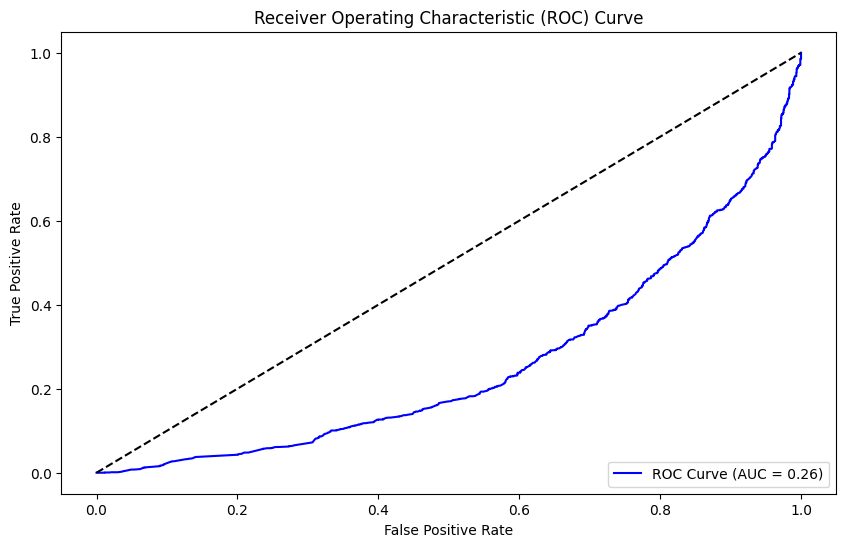

In [ ]:
# Assuming Y_pred_prob is correctly in format (probabilities for the positive class)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)
print("ROC AUC Score: ", roc_auc)

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(Y_test, Y_pred_prob)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC: ", pr_auc)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ROC AUC Score for class 0: 0.93
ROC AUC Score for class 1: 0.89
ROC AUC Score for class 2: nan


c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Karthik Sundaram\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


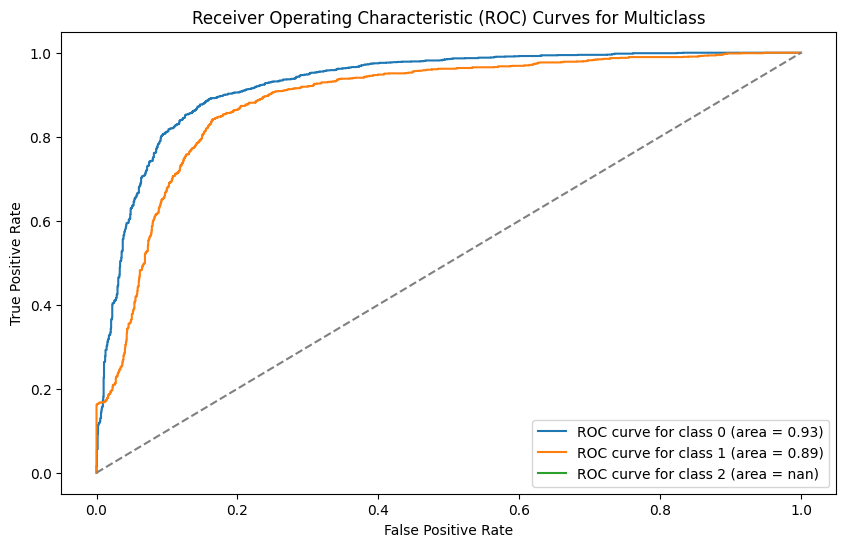

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

# XGBoost model for multiclass classification
xgb_model = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", num_class=3)

# Hyperparameter tuning (make sure to use appropriate scoring for multiclass)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc_ovr')
grid_search.fit(X_train, y_train)

# Best model after GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Model evaluation
y_pred_proba = best_xgb_model.predict_proba(X_test)

# Calculate ROC AUC for each class
roc_auc_scores = {}
for i in range(y_pred_proba.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc_scores[i] = auc(fpr, tpr)

# Print ROC AUC scores for each class
for class_label, score in roc_auc_scores.items():
    print(f"ROC AUC Score for class {class_label}: {score:.2f}")

# Plotting the ROC curves for each class can also be done
plt.figure(figsize=(10, 6))
for i in range(y_pred_proba.shape[1]):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve for class {i} (area = {roc_auc_scores[i]:.2f})')
    
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Multiclass')
plt.legend(loc="lower right")
plt.show()